In [1]:
import nest_asyncio
nest_asyncio.apply()
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import math
import stan
import arviz as az

/home/woejozney/miniconda3/envs/ds/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def local_level(num_timesteps=60, init_mu=10, 
                s_obs = 2, s_level=1,
                seeded=False, seed=None):

    if seeded:
        np.random.seed(seed)
    
    mu = np.zeros(num_timesteps+1)
    y = np.zeros(num_timesteps)
    
    mu_err = np.random.normal(loc=0, scale=1, size=num_timesteps)
    obs_err = np.random.normal(loc=0, scale=1, size=num_timesteps)

    # Get seasonal effects
    mu[0] = init_mu

    for t in range(num_timesteps):
        mu[t+1] = mu[t] + s_level * mu_err[t]
        y[t] = mu[t] + s_obs * obs_err[t]

    return mu, y

In [3]:
N = 100
s_obs = 2
s_level = 1

mu, y = local_level(num_timesteps=N, s_obs=s_obs, s_level=s_level, seeded=True, seed=5)

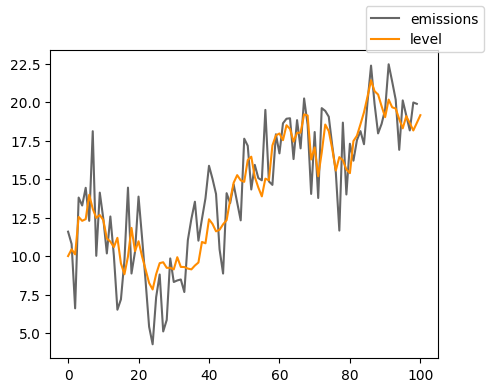

In [4]:
fig, ax = plt.subplots(1, figsize=(5,4))
ax.plot(y, label='emissions', color='k', alpha=.6)
ax.plot(mu, label = 'level', color='darkorange')
fig.legend()

In [11]:
level_code = """
data {
  int<lower=0> N;         // # observations
  real y[N];              // observations
}
parameters {
  vector[N] mu_err;       // level innovation
  vector[N] obs_err;       // level innovation
  real<lower=0> s_level;
  real<lower=0> s_obs;
}
transformed parameters {
  vector[N] mu;           // level 
  mu[1] = mu_err[1];

  for (t in 2:N) {
    mu[t] = mu[t-1] + s_level * mu_err[t];
  }
}
model {
  mu_err ~ normal(0,1);
  obs_err ~ normal(0,1);
  s_obs ~ normal(0, 1);
  s_level ~ normal(0, 5);

  y ~ normal(mu, s_obs);
}
generated quantities {
  vector[N] y_hat;
  
  for (t in 1:N) {
    y_hat[t] = mu[t] + s_obs * obs_err[t];
  }

}
"""

In [12]:
level_data = {"N": N,
                "y": y,}
level_data

{'N': 100,
 'y': array([11.58484523, 10.78275639,  6.60287561, 13.80172148, 13.28569482,
        14.43492145, 12.28819012, 18.11351021, 10.01548606, 14.12176804,
        12.429902  , 10.17096165, 12.57261516, 10.01866124,  6.51374945,
         7.18564766,  9.73534166, 14.44734775,  8.86622914, 10.28367735,
        13.86388258, 11.19554824,  8.37371276,  5.40922617,  4.26826474,
         7.33119559,  8.80260938,  5.10033642,  5.84791172,  9.84584758,
         8.31463553,  8.41601234,  8.47906356,  7.66265746, 11.04187179,
        12.41443935, 13.53097994, 11.00100469, 12.41056273, 13.7555729 ,
        15.86781186, 15.01547098, 14.0318966 , 10.43876298,  8.86410945,
        14.08742449, 13.43741735, 14.65308315, 13.48002415, 12.32062646,
        17.62624826, 17.16551502, 14.32650192, 15.92663524, 15.06742914,
        14.92241454, 19.49746196, 14.85435214, 14.62461675, 17.91356787,
        16.67257624, 18.62672117, 18.92284972, 18.95405716, 16.30282787,
        18.83242054, 16.99730913, 2

In [13]:
%%capture
model = stan.build(level_code, data=level_data, random_seed=1);
posterior = model.sample(num_chains=4, num_samples=1000)

/home/woejozney/.cache/httpstan/4.9.1/models/kgnenn4x/model_kgnenn4x.cpp: In constructor ‘model_kgnenn4x_namespace::model_kgnenn4x::model_kgnenn4x(stan::io::var_context&, unsigned int, std::ostream*)’:
/home/woejozney/.cache/httpstan/4.9.1/models/kgnenn4x/model_kgnenn4x.cpp:71:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
   71 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
In file included from /home/woejozney/miniconda3/envs/ds/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/woejozney/miniconda3/envs/ds/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/woejozney/miniconda3/envs/ds/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/woejozney/miniconda3/envs/ds/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /hom

In [8]:
idata = az.from_pystan(posterior=posterior, posterior_predictive=["y_hat"], posterior_model=model, observed_data=['y'])
fitsum = az.summary(posterior)
fitsum

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_err[0],3.603,0.892,1.912,5.252,0.014,0.010,4141.0,3022.0,1.0
mu_err[1],2.392,0.759,1.025,3.859,0.011,0.008,4693.0,3034.0,1.0
mu_err[2],1.122,0.859,-0.374,2.859,0.015,0.011,3499.0,3061.0,1.0
mu_err[3],1.772,0.814,0.223,3.265,0.012,0.009,4936.0,3148.0,1.0
mu_err[4],0.910,0.819,-0.575,2.506,0.012,0.010,4340.0,3076.0,1.0
...,...,...,...,...,...,...,...,...,...
y_hat[95],19.232,2.412,14.776,23.789,0.033,0.023,5383.0,2924.0,1.0
y_hat[96],19.195,2.402,14.636,23.726,0.033,0.023,5419.0,3344.0,1.0
y_hat[97],19.045,2.428,14.464,23.572,0.032,0.022,5952.0,3003.0,1.0
y_hat[98],19.525,2.548,14.875,24.451,0.035,0.025,5251.0,3036.0,1.0


In [14]:
print(fitsum['s_obs':'s_obs'])
print(fitsum['s_level':'s_level'])

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
s_obs  2.087  0.198   1.718    2.447      0.004    0.003    2134.0    2712.0   

       r_hat  
s_obs    1.0  
         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
s_level  1.42  0.242   1.001    1.885      0.007    0.005    1200.0    2167.0   

         r_hat  
s_level    1.0  


In [9]:
print(fitsum['s_obs':'s_obs'])
print(fitsum['s_level':'s_level'])

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
s_obs  2.087  0.198   1.718    2.447      0.004    0.003    2134.0    2712.0   

       r_hat  
s_obs    1.0  
         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
s_level  1.42  0.242   1.001    1.885      0.007    0.005    1200.0    2167.0   

         r_hat  
s_level    1.0  


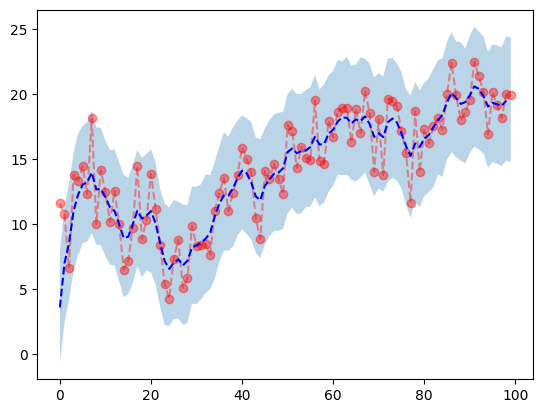

In [10]:
plt.fill_between(
    range(0,100),
    fitsum['y_hat[0]':'y_hat[99]']['hdi_97%'].values,
    fitsum['y_hat[0]':'y_hat[99]']['hdi_3%'].values,
    alpha=.3
    )
plt.plot(y, linestyle="--", marker="o", alpha=.4, color='r')
plt.plot(fitsum['mu[0]':'mu[98]']['mean'].values, color='b', linestyle="--")
